# Scratch

To be deleted, used for fast experimentation.

In [ ]:
# ## Solve dependency problem
# !git clone https://github.com/josipd/torch-two-sample.git
# %cd torch-two-sample
# !python setup.py install

In [1]:
import numpy as np
import torch
import random
# from torch_two_sample import *
from scipy.stats import ks_2samp, binom_test, chisquare, chi2_contingency, anderson_ksamp
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import scipy.io
from math import ceil
from copy import deepcopy
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from tensorflow.python import keras
from tensorflow.python.keras import layers

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Mount drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Run utility functions
%run drive/MyDrive/Colab\ Notebooks/MPhil\ Prototype/Utilities.ipynb

## Load Dataset

In [4]:
# Load dataset, split into train test
path = 'drive/MyDrive/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
x_train, x_test, y_train, y_test, c_train, c_test = load_dsprites(path, 100000, train_size=0.85, class_index=1)

# Split training into validation set as well 
x_train, x_valid = x_train[:70000], x_train[70000:]
y_train, y_valid = y_train[:70000], y_train[70000:]
c_train, c_valid = c_train[:70000], c_train[70000:]

Training samples: 85000
Testing samples: 15000


In [5]:
# Reshape to appropriate shift input
# It is noteworthy that for efficiency, we represent the images as only 2 dimension
# when we preprocessing (number of instances/ batch size * flatten size).
# When visualising back the image, we need to reshape it back to the original dimension
ORIGINAL_SHAPE = x_test.shape[1:] # constant hold the image original shape
x_test_flatten = deepcopy(x_test.reshape(x_test.shape[0], -1))

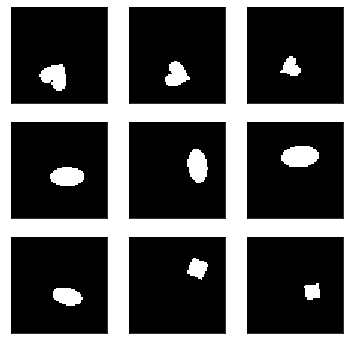

In [6]:
# Select images
imgs_sampled = x_test_flatten[:10].reshape(-1, 64, 64)

# Show images
show_images_grid(imgs_sampled, num_images=9)

## Apply Shifts (Translation)

In [47]:
def translate(x, orig_dims, delta=1.0):
    
    # Random indices where we will apply shift transformation
    indices = np.random.choice(x.shape[0], ceil(x.shape[0] * delta), replace=False)
    datagen = ImageDataGenerator(
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 fill_mode="nearest")
    
    # Subset of images with random indices
    x_mod = x[indices, :]
    for idx in range(len(x_mod)):
        img_sample = x_mod[idx, :].reshape(orig_dims) # reshape single image to original image
        mod_img_sample = datagen.flow(np.array([img_sample]), batch_size=1)[0]
        x_mod[idx, :] = mod_img_sample.reshape(np.prod(mod_img_sample.shape))
    x[indices, :] = x_mod
    
    return x, indices

In [48]:
x_test_flatten_shifted, _ = translate(deepcopy(x_test_flatten), ORIGINAL_SHAPE)

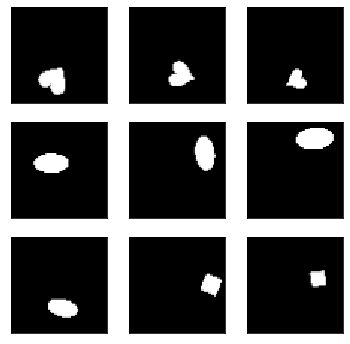

In [49]:
# Select images
imgs_sampled = x_test_flatten_shifted[:10].reshape(-1, 64, 64)

# Show images
show_images_grid(imgs_sampled, num_images=9)

## CBM

In [ ]:
multitask_model = MultitaskModel()
optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
multitask_model.compile(optimizer=optimizer,
                    loss=[
                        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
                    ], metrics=["accuracy"])
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)

history = multitask_model.fit(x=x_train, y=[c_train[:, 0], c_train[:, 1], c_train[:, 2]
                                  , c_train[:, 3], c_train[:, 4], c_train[:, 5]], 
                    epochs=200, batch_size=128,
                    validation_data=(x_valid, [c_valid[:, 0], c_valid[:, 1], c_valid[:, 2]
                                  , c_valid[:, 3], c_valid[:, 4], c_valid[:, 5]]),
                              callbacks=[lr_reducer, early_stopper])

In [10]:
# Save model
path = "drive/MyDrive/multitask_saved_model/"
# multitask_model.save(path)
model = keras.models.load_model(path)

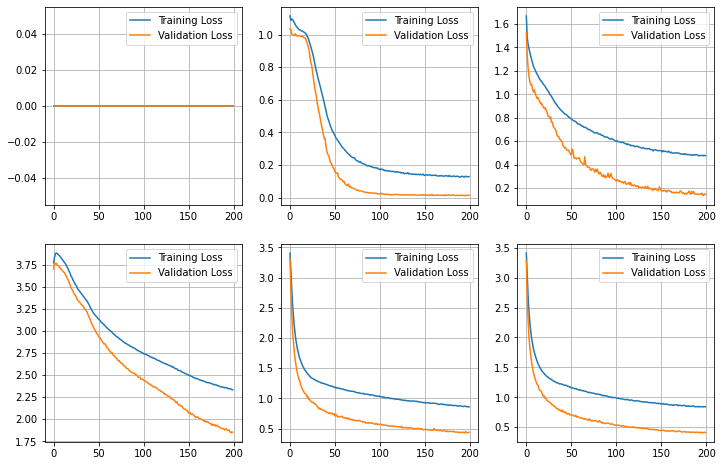

In [17]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

# Plot training validation loss
ax1.plot(history.history["color_loss"], label="Training Loss")
ax1.plot(history.history["val_color_loss"], label="Validation Loss")

ax2.plot(history.history["shape_loss"], label="Training Loss")
ax2.plot(history.history["val_shape_loss"], label="Validation Loss")

ax3.plot(history.history["scale_loss"], label="Training Loss")
ax3.plot(history.history["val_scale_loss"], label="Validation Loss")

ax4.plot(history.history["rotation_loss"], label="Training Loss")
ax4.plot(history.history["val_rotation_loss"], label="Validation Loss")

ax5.plot(history.history["x_loss"], label="Training Loss")
ax5.plot(history.history["val_x_loss"], label="Validation Loss")

ax6.plot(history.history["y_loss"], label="Training Loss")
ax6.plot(history.history["val_y_loss"], label="Validation Loss")

for ax in axes:
    ax.legend()
    ax.grid(True)
plt.show()

In [18]:
# Evaluation
concept_names = ["color", "shape", "scale", "rotation", "x", "y"]
for i, pred in enumerate(model.predict(x_test)):
    print("*"*20, f"Model: {concept_names[i]}", "*"*20)
    c_truth = c_test[:, i]
    c_pred = np.argmax(pred, axis=1)
    
    print(classification_report(c_truth, c_pred))
    print(confusion_matrix(c_truth, c_pred))
    print("\n\n")

******************** Model: color ********************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15000

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000

[[15000]]



******************** Model: shape ********************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4945
           1       1.00      1.00      1.00      5023
           2       1.00      1.00      1.00      5032

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000

[[4945    0    0]
 [   0 5023    0]
 [   0    0 5032]]



******************** Model: scale ********************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2444
 

## Output to Concept Model

In [106]:
from sklearn.linear_model import LogisticRegression

In [107]:
# Build and train model
com = LogisticRegression()
com.fit(c_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [108]:
y_test_pred = com.predict(c_test)
print(classification_report(y_test_pred, y_test))
print(confusion_matrix(y_test_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4964
           1       1.00      1.00      1.00      4975
           2       1.00      1.00      1.00      5061

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000

[[4964    0    0]
 [   0 4975    0]
 [   0    0 5061]]


## Results

In [11]:
multitask_model = model

### BBSDs

In [66]:
## Valid reduced representation
concept_names = ["color", "shape", "scale", "rotation", "x", "y"]
preds = multitask_model.predict(x_test)
color_repr_valid = preds[0]
shape_repr_valid = preds[1]
scale_repr_valid = preds[2]
rotation_repr_valid = preds[3]
x_repr_valid = preds[4]
y_repr_valid = preds[5]

# Store in list
repr_valids = [color_repr_valid, shape_repr_valid, scale_repr_valid, rotation_repr_valid, x_repr_valid, y_repr_valid]

In [71]:
# translate test reduced representation
translate_preds = multitask_model.predict(x_test_flatten_shifted[:500].reshape(-1, 
                                                                        ORIGINAL_SHAPE[0], 
                                                                        ORIGINAL_SHAPE[1],
                                                                        ORIGINAL_SHAPE[2]))
color_repr_translate = translate_preds[0]
shape_repr_translate = translate_preds[1]
scale_repr_translate = translate_preds[2]
rotation_repr_translate = translate_preds[3]
x_repr_translate = translate_preds[4]
y_repr_translate = translate_preds[5]

# Store in list
repr_translates = [color_repr_translate, shape_repr_translate, scale_repr_translate, rotation_repr_translate, x_repr_translate, y_repr_translate]

In [72]:
## Statistical test (Multiple uni)
classes = [1, 3, 6, 40, 32, 32]
for concept, repr_valid, repr_translate in zip(concept_names, repr_valids, repr_translates):
    print("\n", "*"*20, concept, "*"*20)
    p_val, p_vals, t_vals = one_dimensional_test(repr_valid, repr_translate)
    alpha = 0.05 / repr_valid.shape[1] # Divided by number of components for Bonferroni correction
    print(f"Minimum p-value: {p_val}")
    print(f"Component p-values: {p_vals}")
    print(f"Test statistics: {t_vals}")
    print(f"Average test statistics: {np.mean(t_vals)}")
    print(f"Average p-values: {np.mean(p_vals)}")

    if p_val < alpha:
        print("Minimum p-value < alpha; reject H0")
    else:
        print("Minimum p-value > alpha; not reject H0")


 ******************** color ********************
Minimum p-value: 1.0
Component p-values: [1.]
Test statistics: [-0.0]
Average test statistics: 0.0
Average p-values: 1.0
Minimum p-value > alpha; not reject H0

 ******************** shape ********************
Minimum p-value: 4.042086278822509e-06
Component p-values: [4.74679830e-04 9.11402766e-06 4.04208628e-06]
Test statistics: [0.09286666666666665, 0.11273333333333335, 0.11639999999999995]
Average test statistics: 0.10733333333333332
Average p-values: 0.0001626119812416977
Minimum p-value < alpha; reject H0

 ******************** scale ********************
Minimum p-value: 8.353022727757004e-07
Component p-values: [1.23189554e-03 8.35302273e-07 6.85380301e-04 4.12705741e-01
 1.95667070e-01 2.04451159e-01]
Test statistics: [0.08739999999999992, 0.12319999999999998, 0.09079999999999999, 0.04026666666666667, 0.049000000000000044, 0.04853333333333332]
Average test statistics: 0.07319999999999999
Average p-values: 0.13579034688266733
Min

### BBSDh (Concepts)
Using the hard outputs (prediction) of the models as reduced representation.

In [56]:
## Valid reduced representation
concept_names = ["color", "shape", "scale", "rotation", "x", "y"]
preds = multitask_model.predict(x_test)
color_repr_valid = np.argmax(preds[0], axis=1)
shape_repr_valid = np.argmax(preds[1], axis=1)
scale_repr_valid = np.argmax(preds[2], axis=1)
rotation_repr_valid = np.argmax(preds[3], axis=1)
x_repr_valid = np.argmax(preds[4], axis=1)
y_repr_valid = np.argmax(preds[5], axis=1)

# Store in list
repr_valids = [color_repr_valid, shape_repr_valid, scale_repr_valid, rotation_repr_valid, x_repr_valid, y_repr_valid]

In [59]:
translate_preds = multitask_model.predict(x_test_flatten_shifted[:500].reshape(-1, 
                                                                        ORIGINAL_SHAPE[0], 
                                                                        ORIGINAL_SHAPE[1],
                                                                        ORIGINAL_SHAPE[2]))

color_repr_translate = np.argmax(translate_preds[0], axis=1)
shape_repr_translate = np.argmax(translate_preds[1], axis=1)
scale_repr_translate = np.argmax(translate_preds[2], axis=1)
rotation_repr_translate = np.argmax(translate_preds[3], axis=1)
x_repr_translate = np.argmax(translate_preds[4], axis=1)
y_repr_translate = np.argmax(translate_preds[5], axis=1)

# Store in list
repr_translates = [color_repr_translate, shape_repr_translate, scale_repr_translate, rotation_repr_translate, x_repr_translate, y_repr_translate]

In [60]:
## Statistical test
classes = [1, 3, 6, 40, 32, 32]
for concept, repr_valid, repr_translate, num_classes in zip(concept_names, repr_valids, repr_translates, classes):
    print("\n", "*"*20, concept, "*"*20)
    chi2, p_val = test_chi2_shift(repr_valid, repr_translate, num_classes)
    alpha = 0.05
    print(f"p-value: {p_val}")
    print(f"Test statistics: {chi2}")

    if p_val < alpha:
        print("Minimum p-value < alpha; reject H0")
    else:
        print("Minimum p-value > alpha; not reject H0")


 ******************** color ********************
p-value: 1.0
Test statistics: 0.0
Minimum p-value > alpha; not reject H0

 ******************** shape ********************
p-value: 0.005230532894388176
Test statistics: 10.506484228487007
Minimum p-value < alpha; reject H0

 ******************** scale ********************
p-value: 0.10328399571199252
Test statistics: 9.148541926956808
Minimum p-value > alpha; not reject H0

 ******************** rotation ********************
p-value: 0.0007302479510652846
Test statistics: 73.27622151529104
Minimum p-value < alpha; reject H0

 ******************** x ********************
p-value: 3.078084949163713e-23
Test statistics: 181.70771122260982
Minimum p-value < alpha; reject H0

 ******************** y ********************
p-value: 7.125383828136378e-22
Test statistics: 174.21926288188803
Minimum p-value < alpha; reject H0


In [89]:
pd.DataFrame(y_repr_translate == y_repr_valid).value_counts()

True     13514
False     1486
dtype: int64

In [90]:
pd.DataFrame(shape_repr_translate == shape_repr_valid).value_counts()

True     14469
False      531
dtype: int64

In [91]:
pd.DataFrame(scale_repr_translate == scale_repr_valid).value_counts()

True     13633
False     1367
dtype: int64

In [92]:
pd.DataFrame(x_repr_translate == x_repr_valid).value_counts()

False    14140
True       860
dtype: int64

#### Setting 2

In [61]:
## Valid reduced representation
concept_names = ["color", "shape", "scale", "rotation", "x", "y"]
preds = multitask_model.predict(x_valid)
color_repr_valid = np.argmax(preds[0], axis=1)
shape_repr_valid = np.argmax(preds[1], axis=1)
scale_repr_valid = np.argmax(preds[2], axis=1)
rotation_repr_valid = np.argmax(preds[3], axis=1)
x_repr_valid = np.argmax(preds[4], axis=1)
y_repr_valid = np.argmax(preds[5], axis=1)

# Store in list
repr_valids = [color_repr_valid, shape_repr_valid, scale_repr_valid, rotation_repr_valid, x_repr_valid, y_repr_valid]

In [64]:
translate_preds = multitask_model.predict(x_test_flatten_shifted[:200].reshape(-1, 
                                                                        ORIGINAL_SHAPE[0], 
                                                                        ORIGINAL_SHAPE[1],
                                                                        ORIGINAL_SHAPE[2]))

color_repr_translate = np.argmax(translate_preds[0], axis=1)
shape_repr_translate = np.argmax(translate_preds[1], axis=1)
scale_repr_translate = np.argmax(translate_preds[2], axis=1)
rotation_repr_translate = np.argmax(translate_preds[3], axis=1)
x_repr_translate = np.argmax(translate_preds[4], axis=1)
y_repr_translate = np.argmax(translate_preds[5], axis=1)

# Store in list
repr_translates = [color_repr_translate, shape_repr_translate, scale_repr_translate, rotation_repr_translate, x_repr_translate, y_repr_translate]

In [65]:
## Statistical test
classes = [1, 3, 6, 40, 32, 32]
for concept, repr_valid, repr_translate, num_classes in zip(concept_names, repr_valids, repr_translates, classes):
    print("\n", "*"*20, concept, "*"*20)
    chi2, p_val = test_chi2_shift(repr_valid, repr_translate, num_classes)
    alpha = 0.05
    print(f"p-value: {p_val}")
    print(f"Test statistics: {chi2}")

    if p_val < alpha:
        print("Minimum p-value < alpha; reject H0")
    else:
        print("Minimum p-value > alpha; not reject H0")


 ******************** color ********************
p-value: 1.0
Test statistics: 0.0
Minimum p-value > alpha; not reject H0

 ******************** shape ********************
p-value: 0.08107569072920214
Test statistics: 5.024744214385164
Minimum p-value > alpha; not reject H0

 ******************** scale ********************
p-value: 0.3945026930447138
Test statistics: 5.178363886834981
Minimum p-value > alpha; not reject H0

 ******************** rotation ********************
p-value: 0.25050589904141035
Test statistics: 44.52409652054098
Minimum p-value > alpha; not reject H0

 ******************** x ********************
p-value: 1.4431299573976398e-06
Test statistics: 82.53540428990115
Minimum p-value < alpha; reject H0

 ******************** y ********************
p-value: 4.308911266260395e-06
Test statistics: 79.18907699694307
Minimum p-value < alpha; reject H0


### Show that improves detection accuracy

#### BBSDH

In [95]:
## Valid reduced representation
concept_names = ["color", "shape", "scale", "rotation", "x", "y"]
preds = multitask_model.predict(x_test)
color_repr_valid = np.argmax(preds[0], axis=1)
shape_repr_valid = np.argmax(preds[1], axis=1)
scale_repr_valid = np.argmax(preds[2], axis=1)
rotation_repr_valid = np.argmax(preds[3], axis=1)
x_repr_valid = np.argmax(preds[4], axis=1)
y_repr_valid = np.argmax(preds[5], axis=1)

# Store in list
repr_valids = [color_repr_valid, shape_repr_valid, scale_repr_valid, rotation_repr_valid, x_repr_valid, y_repr_valid]
repr_valids = np.array(repr_valids).T

In [97]:
translate_preds = multitask_model.predict(x_test_flatten_shifted[:200].reshape(-1, 
                                                                        ORIGINAL_SHAPE[0], 
                                                                        ORIGINAL_SHAPE[1],
                                                                        ORIGINAL_SHAPE[2]))

color_repr_translate = np.argmax(translate_preds[0], axis=1)
shape_repr_translate = np.argmax(translate_preds[1], axis=1)
scale_repr_translate = np.argmax(translate_preds[2], axis=1)
rotation_repr_translate = np.argmax(translate_preds[3], axis=1)
x_repr_translate = np.argmax(translate_preds[4], axis=1)
y_repr_translate = np.argmax(translate_preds[5], axis=1)

# Store in list
repr_translates = [color_repr_translate, shape_repr_translate, scale_repr_translate, rotation_repr_translate, x_repr_translate, y_repr_translate]
repr_translates = np.array(repr_translates).T

In [98]:
# Fit to concept to output
valid_dr = com.predict(repr_valids)
test_dr = com.predict(repr_translates)

In [99]:
chi2, p_val = test_chi2_shift(valid_dr, test_dr, 3)
alpha = 0.05
print(f"p-value: {p_val}")
print(f"Test statistics: {chi2}")

if p_val < alpha:
    print("Minimum p-value < alpha; reject H0")
else:
    print("Minimum p-value > alpha; not reject H0")

p-value: 0.07779264689671057
Test statistics: 5.107416730320335
Minimum p-value > alpha; not reject H0


#### Method 2 Our concept-based BBSD

In [100]:
## Valid reduced representation
concept_names = ["color", "shape", "scale", "rotation", "x", "y"]
preds = multitask_model.predict(x_test)
color_repr_valid = np.argmax(preds[0], axis=1)
shape_repr_valid = np.argmax(preds[1], axis=1)
scale_repr_valid = np.argmax(preds[2], axis=1)
rotation_repr_valid = np.argmax(preds[3], axis=1)
x_repr_valid = np.argmax(preds[4], axis=1)
y_repr_valid = np.argmax(preds[5], axis=1)

# Store in list
repr_valids = [color_repr_valid, shape_repr_valid, scale_repr_valid, rotation_repr_valid, x_repr_valid, y_repr_valid]

In [101]:
translate_preds = multitask_model.predict(x_test_flatten_shifted[:200].reshape(-1, 
                                                                        ORIGINAL_SHAPE[0], 
                                                                        ORIGINAL_SHAPE[1],
                                                                        ORIGINAL_SHAPE[2]))

color_repr_translate = np.argmax(translate_preds[0], axis=1)
shape_repr_translate = np.argmax(translate_preds[1], axis=1)
scale_repr_translate = np.argmax(translate_preds[2], axis=1)
rotation_repr_translate = np.argmax(translate_preds[3], axis=1)
x_repr_translate = np.argmax(translate_preds[4], axis=1)
y_repr_translate = np.argmax(translate_preds[5], axis=1)

# Store in list
repr_translates = [color_repr_translate, shape_repr_translate, scale_repr_translate, rotation_repr_translate, x_repr_translate, y_repr_translate]

In [102]:
## Statistical test
classes = [1, 3, 6, 40, 32, 32]
for concept, repr_valid, repr_translate, num_classes in zip(concept_names, repr_valids, repr_translates, classes):
    print("\n", "*"*20, concept, "*"*20)
    chi2, p_val = test_chi2_shift(repr_valid, repr_translate, num_classes)
    alpha = 0.05
    print(f"p-value: {p_val}")
    print(f"Test statistics: {chi2}")

    if p_val < alpha:
        print("Minimum p-value < alpha; reject H0")
    else:
        print("Minimum p-value > alpha; not reject H0")


 ******************** color ********************
p-value: 1.0
Test statistics: 0.0
Minimum p-value > alpha; not reject H0

 ******************** shape ********************
p-value: 0.07779264689671057
Test statistics: 5.107416730320335
Minimum p-value > alpha; not reject H0

 ******************** scale ********************
p-value: 0.45422383183056747
Test statistics: 4.695002957281247
Minimum p-value > alpha; not reject H0

 ******************** rotation ********************
p-value: 0.20081203915394183
Test statistics: 46.144388498725604
Minimum p-value > alpha; not reject H0

 ******************** x ********************
p-value: 1.2683513863469807e-07
Test statistics: 89.75202125801249
Minimum p-value < alpha; reject H0

 ******************** y ********************
p-value: 2.323018120950705e-06
Test statistics: 81.08762601526878
Minimum p-value < alpha; reject H0


#### Method 3 BBSDs Logistic Regression

In [113]:
## Valid reduced representation
concept_names = ["color", "shape", "scale", "rotation", "x", "y"]
preds = multitask_model.predict(x_test)
color_repr_valid = np.argmax(preds[0], axis=1)
shape_repr_valid = np.argmax(preds[1], axis=1)
scale_repr_valid = np.argmax(preds[2], axis=1)
rotation_repr_valid = np.argmax(preds[3], axis=1)
x_repr_valid = np.argmax(preds[4], axis=1)
y_repr_valid = np.argmax(preds[5], axis=1)

# Store in list
repr_valids = [color_repr_valid, shape_repr_valid, scale_repr_valid, rotation_repr_valid, x_repr_valid, y_repr_valid]
repr_valids = np.array(repr_valids).T

In [114]:
translate_preds = multitask_model.predict(x_test_flatten_shifted[:200].reshape(-1, 
                                                                        ORIGINAL_SHAPE[0], 
                                                                        ORIGINAL_SHAPE[1],
                                                                        ORIGINAL_SHAPE[2]))

color_repr_translate = np.argmax(translate_preds[0], axis=1)
shape_repr_translate = np.argmax(translate_preds[1], axis=1)
scale_repr_translate = np.argmax(translate_preds[2], axis=1)
rotation_repr_translate = np.argmax(translate_preds[3], axis=1)
x_repr_translate = np.argmax(translate_preds[4], axis=1)
y_repr_translate = np.argmax(translate_preds[5], axis=1)

# Store in list
repr_translates = [color_repr_translate, shape_repr_translate, scale_repr_translate, rotation_repr_translate, x_repr_translate, y_repr_translate]
repr_translates = np.array(repr_translates).T

In [122]:
# Fit to concept to output
valid_dr = com.predict_proba(repr_valids)
test_dr = com.predict_proba(repr_translates)

In [124]:
## Statistical test (Multiple uni)
p_val, p_vals, t_vals = one_dimensional_test(valid_dr, test_dr)
alpha = 0.05 / 3 # Divided by number of components for Bonferroni correction
print(f"Minimum p-value: {p_val}")
print(f"Component p-values: {p_vals}")
print(f"Test statistics: {t_vals}")

if p_val < alpha:
    print("Minimum p-value < alpha; reject H0")
else:
    print("Minimum p-value > alpha; not reject H0")

Minimum p-value: 0.08368846077221767
Component p-values: [0.08368846 0.17228792 0.12285251]
Test statistics: [0.08966666666666664, 0.07879999999999998, 0.08406666666666673]
Minimum p-value > alpha; not reject H0
